# 1. Общая информация

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [2]:
try:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone.csv')
except:
    df_contract = pd.read_csv('datasets/contract.csv')
    df_personal = pd.read_csv('datasets/personal.csv')
    df_internet = pd.read_csv('datasets/internet.csv')
    df_phone = pd.read_csv('datasets/phone.csv')

In [3]:
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_contract['target'] = df_contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)
df_contract['EndDate'] = df_contract['EndDate'].apply(lambda x: '2020-02-01 00:00:00' if x=='No' else x)
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d %H:%M:%S')
df_contract =df_contract[df_contract['TotalCharges']!=' '].reset_index(drop=True)
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'])

In [5]:
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 494.6+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


В таблице df_contract изменили тип данных столбца начало и конца использования услуги на datetime.
Удалили 11 строк в которых отсутствовали данные с общим количеством потраченных денег на услуги.
Изменен тип данных на плавающее число в столбце TotalCharges. Добавили столбец target, который описывает ушел клиент или остался.

In [6]:
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [9]:
data = df_personal.merge(df_contract, on='customerID', how='inner')
data = data.merge(df_internet, on='customerID', how='left')
data = data.merge(df_phone, on='customerID', how='left')
data['InternetService'] = data['InternetService'].fillna('not_use')
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('not_use')
data['OnlineBackup'] = data['OnlineBackup'].fillna('not_use')
data['DeviceProtection'] = data['DeviceProtection'].fillna('not_use')
data['TechSupport'] = data['TechSupport'].fillna('not_use')
data['StreamingTV'] = data['StreamingTV'].fillna('not_use')
data['StreamingMovies'] = data['StreamingMovies'].fillna('not_use')
data['MultipleLines'] = data['MultipleLines'].fillna('not_use')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  target            7032 non-null   int64         
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

Получено четыре датафрейма с описанием информации о договоре (df_contract), персональных данных клиента (df_personal), информацией о интернет-услугах (df_internet) и об услугах телефонии(df_phone). Была проведена предобработка данных в таблице df_contract. Была получена общая таблица данных. Пропущенные данные соответствовали не использованию данной услуги (интернета, телефона), о чем была в соответствующих столбцах добавлено значение 'not_use'. Таблица готова к анализу данных.

# 2. Исследовательский анализ данных

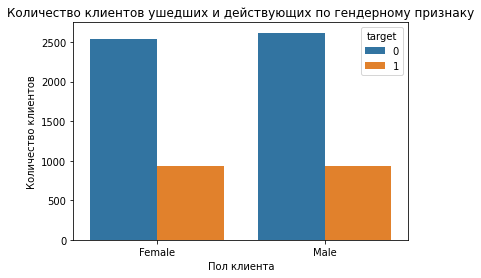

In [10]:
plt.title('Количество клиентов ушедших и действующих по гендерному признаку')
sns.countplot(x='gender', data=data, hue = 'target')
plt.xlabel('Пол клиента')
plt.ylabel('Количество клиентов');

Клиенты по гендеру разделены примерно поровну.

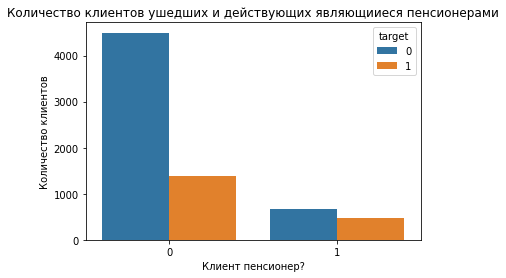

In [11]:
plt.title('Количество клиентов ушедших и действующих являющииеся пенсионерами')
sns.countplot(x='SeniorCitizen', data=data, hue = 'target')
plt.xlabel('Клиент пенсионер?')
plt.ylabel('Количество клиентов');

Пенсионеров подключающих телеком всего 10%. Оставшихся пенсионеров чуть больше, чем ушедших.

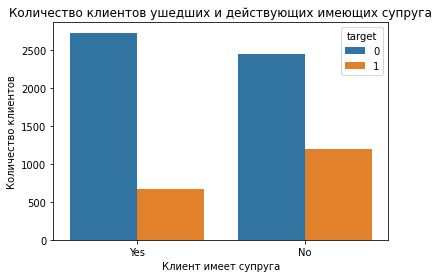

In [12]:
plt.title('Количество клиентов ушедших и действующих имеющих супруга')
sns.countplot(x='Partner', data=data, hue = 'target')
plt.xlabel('Клиент имеет супруга')
plt.ylabel('Количество клиентов');

У оставшихся клиентах чуть больше тех кто имеет супруга. В то время как среди ушедших больше в 2 раза тех кто без супруга.

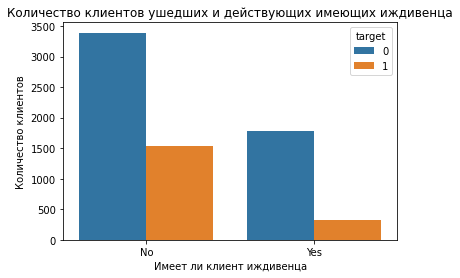

In [13]:
plt.title('Количество клиентов ушедших и действующих имеющих иждивенца')
sns.countplot(x='Dependents', data=data, hue = 'target')
plt.xlabel('Имеет ли клиент иждивенца')
plt.ylabel('Количество клиентов');

У оставшихся клиентах имеющие иждивенца в 2 раза меньше чем неимеющие. Имеющие иждивенца намного чаще остаются чем уходят. 

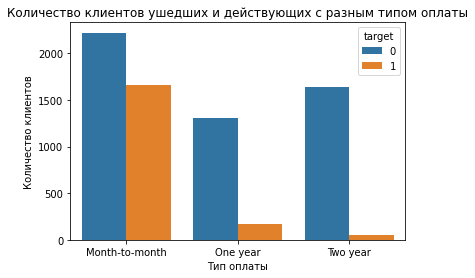

In [14]:
plt.title('Количество клиентов ушедших и действующих с разным типом оплаты')
sns.countplot(x='Type', data=data, hue = 'target')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество клиентов');

Люди чаще выбирают платить раз в месяц, и при этом очень часто уходят. Люди выбирающие в качестве оплаты годовую или двухгодовую подписку почти не уходят.

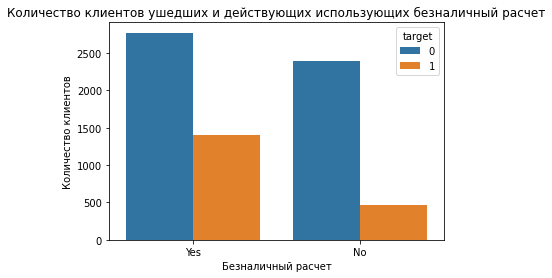

In [15]:
plt.title('Количество клиентов ушедших и действующих использующих безналичный расчет')
sns.countplot(x='PaperlessBilling', data=data, hue = 'target')
plt.xlabel('Безналичный расчет')
plt.ylabel('Количество клиентов');

Людей выбравших безналичный расчет больше. При этом люди не выбравшие безналичный расчет реже уходят.

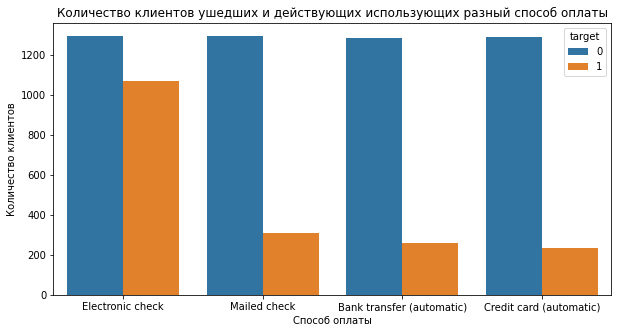

In [16]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих использующих разный способ оплаты')
sns.countplot(x='PaymentMethod', data=data, hue = 'target')
plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов');

Из тех кто остался способ оплаты распределен одинаково. В то время как среди ушедших чаще расплачиваются электронным чеком.

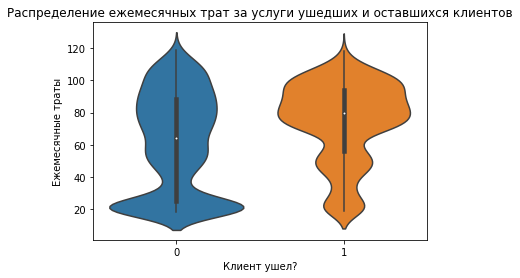

In [17]:
plt.title('Распределение ежемесячных трат за услуги ушедших и оставшихся клиентов')
sns.violinplot(x ='target', y='MonthlyCharges', data=data)
plt.xlabel('Клиент ушел?')
plt.ylabel('Ежемесячные траты');

Как видно ушедшие клиенты тратили в среднем больше, чем оставшиеся. Возможно цена тарифа для них была слишком высока.

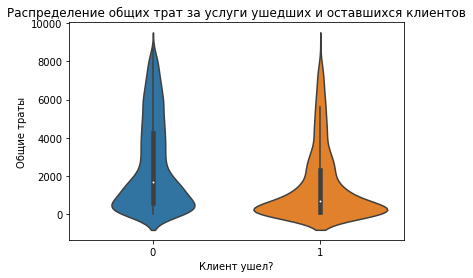

In [18]:
plt.title('Распределение общих трат за услуги ушедших и оставшихся клиентов')
sns.violinplot(x ='target', y='TotalCharges', data=data)
plt.xlabel('Клиент ушел?')
plt.ylabel('Общие траты');

Как видно ушедшие чуть меньше принесли общей выручке. Возможно если бы они остались распределение справа стало выше.

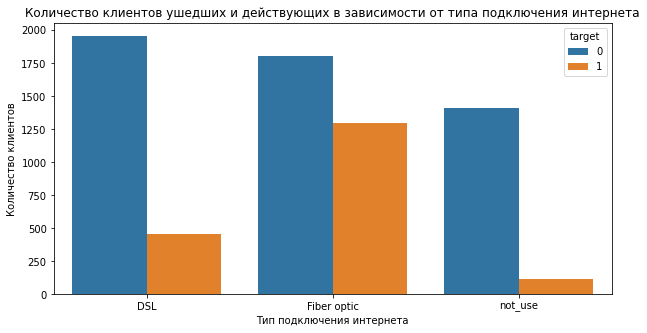

In [19]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих в зависимости от типа подключения интернета')
sns.countplot(x='InternetService', data=data, hue = 'target')
plt.xlabel('Тип подключения интернета')
plt.ylabel('Количество клиентов');

Как видно люди чаще уходили использующие подключение через оптоволоконный кабель. Возможно надо обратить внимание на качество интернета при таком виде подключения.

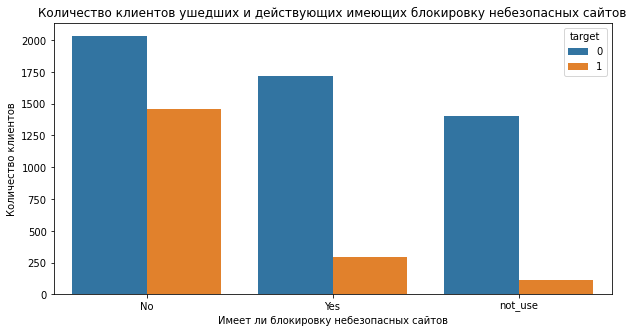

In [20]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих имеющих блокировку небезопасных сайтов')
sns.countplot(x='OnlineSecurity', data=data, hue = 'target')
plt.xlabel('Имеет ли блокировку небезопасных сайтов')
plt.ylabel('Количество клиентов');

Среди всех ушедших намного чаще уходили люди не имеющие блокировку небезопасных сайтов. Возможно нужно уменьшить цену на эту услугу, либо сделать услугу постоянно входящую в тариф.

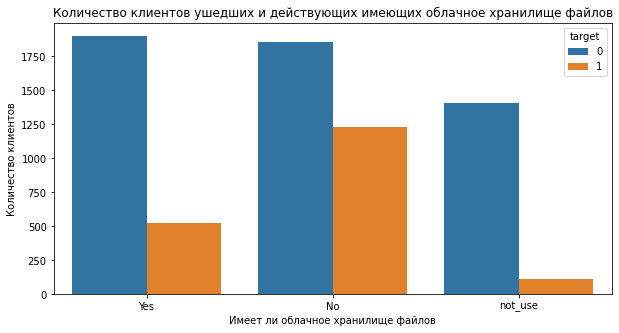

In [21]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих имеющих облачное хранилище файлов')
sns.countplot(x='OnlineBackup', data=data, hue = 'target')
plt.xlabel('Имеет ли облачное хранилище файлов')
plt.ylabel('Количество клиентов');

Как видно оставшиеся клиенты разделены поровну. В то время как среди ушедших больше людей не имело этой услуги. Возможно у людей произошло потеря файлов, и они на эмоциях отказались от тарифа.

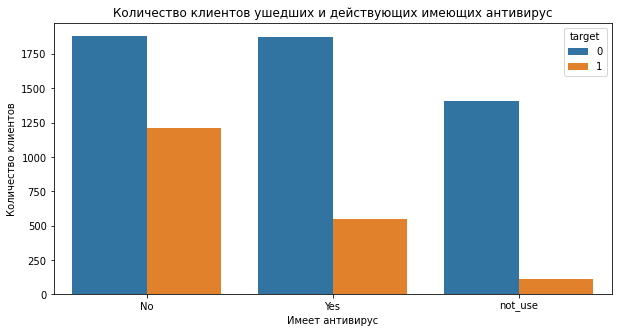

In [22]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих имеющих антивирус')
sns.countplot(x='DeviceProtection', data=data, hue = 'target')
plt.xlabel('Имеет антивирус')
plt.ylabel('Количество клиентов');

Среди оставшихся услуга распределена поровну. В то время как среди ушедших больше людей не имело антивируса. Возможно во время использования интернета произошло заражение компьютера, произошло потеря важной информации. Люди стали винить кампанию и на эмоциях ушли.

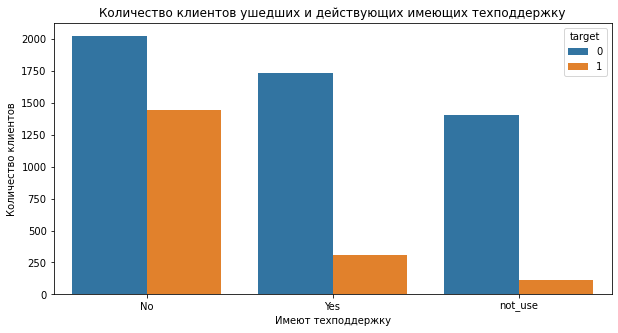

In [23]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих имеющих техподдержку')
sns.countplot(x='TechSupport', data=data, hue = 'target')
plt.xlabel('Имеют техподдержку')
plt.ylabel('Количество клиентов');

Среди ушедших много не имело техподдержку. Возможно надо ввести её бесплатно для всех клиентов.

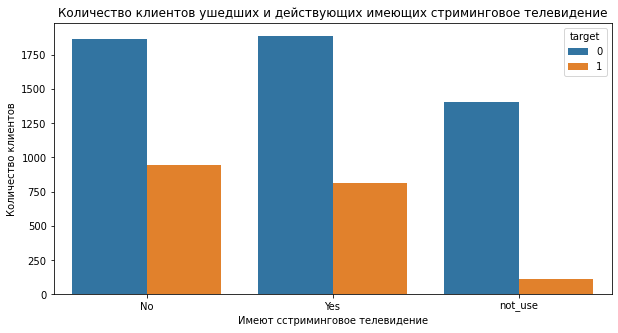

In [24]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих имеющих стриминговое телевидение')
sns.countplot(x='StreamingTV', data=data, hue = 'target')
plt.xlabel('Имеют сстриминговое телевидение')
plt.ylabel('Количество клиентов');

Данная услуга распределена одинаково как для ушедших так и для оставшихся. Возможно причина в том что сегодня немного людей смотрят телевидение. И поэтому люди не обращают внимание на эту услугу.

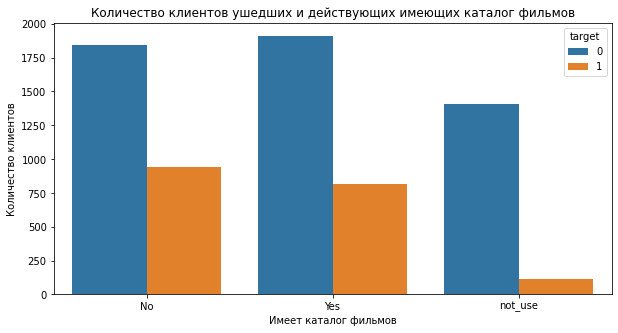

In [25]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих имеющих каталог фильмов')
sns.countplot(x='StreamingMovies', data=data, hue = 'target')
plt.xlabel('Имеет каталог фильмов')
plt.ylabel('Количество клиентов');

Данная услуга распределена одинаково как для ушедших так и для оставшихся. Возможно причина в том что сегодня люди могут бесплатно скачать любой фильм бесплатно. И поэтому люди не обращают внимание на эту услугу.

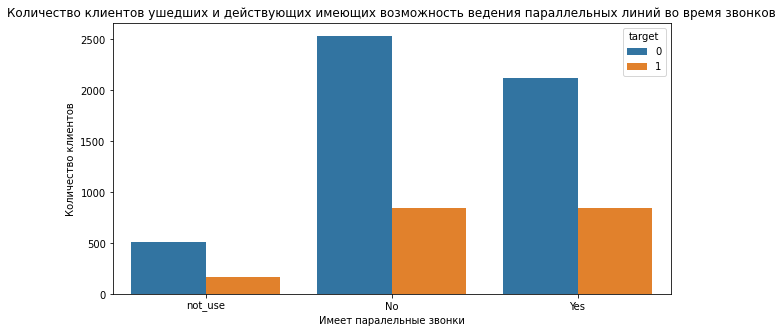

In [26]:
plt.figure(figsize=(10,5))
plt.title('Количество клиентов ушедших и действующих имеющих возможность ведения параллельных линий во время звонков')
sns.countplot(x='MultipleLines', data=data, hue = 'target')
plt.xlabel('Имеет паралельные звонки')
plt.ylabel('Количество клиентов');

Люди оставшиеся чаще не имеют паралельных звонков. Возможно эту услугу выбирают те кому она действительно нужно.

<b>Вывод:</b> Проведен исследовательский анализ данных

План работы:
1. Сформировать обучающую и тестовую выборку.Разбить выборку на обучающую и тестовую в соотношении 4:1
2. На обучающей модели кроссвалидацией построить несколько моделей и рассчитать метрику ROC-AUC. Дополнительно accurancy.
3. Выбрать лучшую модель. Поиграть с моделью добавить новые фичи.
4. Рассчитать процент убытков компании при неправильном ответе модели. Вывести матрицу ошибок.
5. Написать вывод

# 3. Выбор модели

In [27]:
data['day'] = (data['EndDate'] - data['BeginDate']).dt.days
data = data.drop(['customerID', 'EndDate', 'BeginDate'], axis=1)

Добавлен новый признак количество дней использования тарифа. Удалены столбцы мешающие построению взаимосвязей алгоритмам машинного обучения.

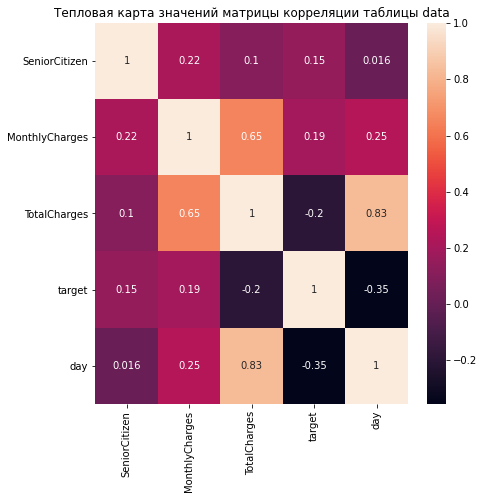

In [28]:
plt.figure(figsize=(7,7))
plt.title('Тепловая карта значений матрицы корреляции таблицы data')
sns.heatmap(data.corr(), annot=True);

In [29]:
data = data.drop(['TotalCharges'], axis=1)

Видна большая корреляция между днями использвания тарифа(day) и общими тратами на тариф (TotalCharges). Удалим столбец TotalCharges.

In [30]:
categorial = data.select_dtypes(include='object').columns
data_ohe = pd.get_dummies(data,drop_first=True,columns=categorial)
encoder = OrdinalEncoder()
data[categorial] = encoder.fit_transform(data[categorial])

Преобразовали категориальные признаки в численные двумя методами: One-hot-encoding(data_ohe, будем использовать для обучения линейной модели) и OrdinalEncoding (data).

In [31]:
df_train1, df_test1 = train_test_split(data_ohe, test_size=0.25, random_state=12345)
features_train1 = df_train1.drop(['target'],axis=1)
target_train1 = df_train1['target']
features_test1 = df_test1.drop(['target'],axis=1)
target_test1 = df_test1['target']

In [32]:
df_train2, df_test2 = train_test_split(data, test_size=0.25, random_state=12345)
features_train2 = df_train2.drop(['target'],axis=1)
target_train2 = df_train2['target']
features_test2 = df_test2.drop(['target'],axis=1)
target_test2 = df_test2['target']

Разделили таблицы на обучающую и тестовую в соотношении 75:25 в зависимости от вида кодирования.

In [33]:
log_param = {
    'logreg__C':[0.1, 0.5, 1, 5, 10, 50, 100],
    'logreg__penalty':['l1','l2']
}
log_pipe = Pipeline(
    [('scaler', StandardScaler()), ('logreg', LogisticRegression(solver='liblinear',random_state=123456 ))]
)
#log_model = LogisticRegression()
log_grid = GridSearchCV(estimator=log_pipe,param_grid=log_param, cv=5, n_jobs=-1, verbose=True, scoring='roc_auc')
log_grid.fit(features_train1, target_train1)
log_grid.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


0.8413916245965407

ROC-AUC линейной модели равен 0,84

In [39]:
rfc_params = {
    'max_depth': [2,4,7,10],
    'n_estimators': [50,100,200,500],
    'min_samples_leaf' : [2, 4, 8, 12],
    'min_samples_split': [2, 4, 8, 12]
}
rfc = RandomForestClassifier(random_state=123456, class_weight='balanced')
rfc_grid = GridSearchCV(rfc,rfc_params, cv=3, n_jobs=-1, verbose=True, scoring='roc_auc')
rfc_grid.fit(features_train2, target_train2)
rfc_grid.best_score_

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  9.0min finished


0.8518510236533493

ROC-AUC модели случайный лес равен 0,85

In [35]:
cat_params = {
    'learning_rate' : [0.03, 0.05, 0.1],
    'depth' : [2,4,6],
    'l2_leaf_reg' : [1,3,5]
}
cat = CatBoostClassifier(verbose=False)
cat_grid = GridSearchCV(estimator=cat, param_grid=cat_params, scoring='roc_auc', cv=3)
cat_grid.fit(features_train2, target_train2 )
cat_grid.best_score_

0.9246077099759269

ROC-AUC модели градиентного бустинга catboost равен 0,92

<b>Вывод наилучшей моделью является градиентный бустинг catboost</b>

In [36]:
cat_grid.best_params_

{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

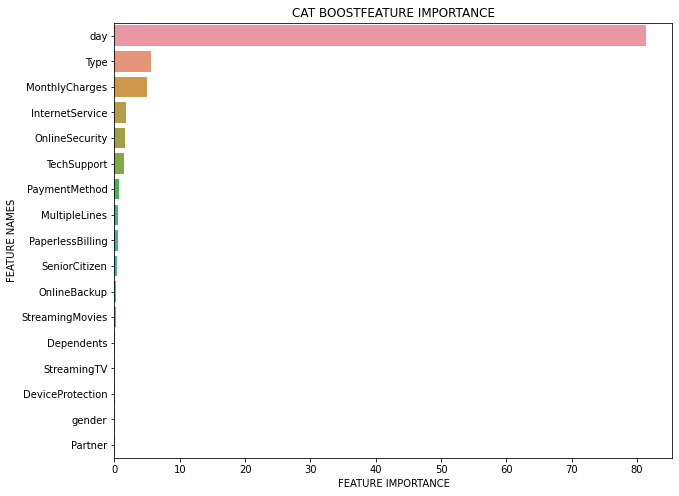

In [34]:
cat_model = CatBoostClassifier(verbose=False, learning_rate=0.1, depth=2, l2_leaf_reg=1 ,random_seed=123456)
cat_model.fit(features_train2, target_train2)


def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    df = pd.DataFrame(data)
    df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=df['feature_importance'], y=df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

plot_feature_importance(cat_model.get_feature_importance(), features_train2.columns,'CAT BOOST')

Как видно по графикам наибольшую важность имеет признак day, MonthlyCharges, Type. Остальные очень малы. Их можно удалить.

In [35]:
features_train_imortance=features_train2[['day','MonthlyCharges', 'Type']]
features_test_imortance=features_test2[['day','MonthlyCharges', 'Type']]

# 4. Тестирование модели

In [37]:
cat_model = CatBoostClassifier(verbose=False, learning_rate=0.1, depth=2, l2_leaf_reg=1 ,random_seed=123456)
cat_model.fit(features_train_imortance, target_train2)
propabilities = cat_model.predict_proba(features_test_imortance)[:,1]
tre = 0.29
pred_valid = propabilities > tre
roc = roc_auc_score(target_test2, pred_valid)
accuracy= accuracy_score(target_test2, pred_valid)
print('ROC-AUC модели градиентного бустинга равна: ',roc)
print('Доля правильных ответов модели градиентного бустинга равна:',accuracy)

ROC-AUC модели градиентного бустинга равна:  0.8587655614599705
Доля правильных ответов модели градиентного бустинга равна: 0.8742889647326507


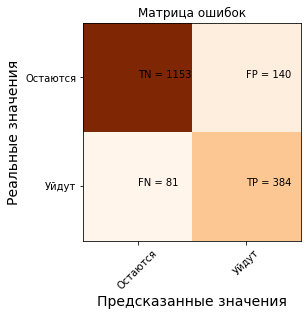

In [41]:
plt.clf()
cm = confusion_matrix(target_test2, pred_valid)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
classNames = ['Остаются','Уйдут']
plt.title('Матрица ошибок')

plt.ylabel('Реальные значения', fontsize=14)
plt.xlabel('Предсказанные значения', fontsize=14)

tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Построена матрица ошибок окончательной модели.

<b>Вывод: </b> Заметно небольшое переобучение модели. Модель готова к выпуску в продакшн.

## 5. Итоговый вывод

1) Был проведен исследовательский анализ данных в результате которого было выявлено:
* Клиенты по полу разделены одинаковы 
* Пенсионеров подключающих телеком всего 10%. Оставшихся пенсионеров чуть больше, чем ушедших.
* У оставшихся клиентах чуть больше тех кто имеет супруга. В то время как среди ушедших больше в 2 раза тех кто без супруга.
* У оставшихся клиентах имеющие иждивенца в 2 раза меньше чем неимеющие. Имеющие иждивенца намного чаще остаются чем уходят.
* Люди чаще выбирают платить раз в месяц, и при этом очень часто уходят. Люди выбирающие в качестве оплаты годовую или двухгодовую подписку почти не уходят.
* Людей выбравших безналичный расчет больше. При этом люди не выбравшие безналичный расчет реже уходят.
* Ушедшие чаще расплачивались электронным чеком.
* Ушедшие чуть меньше принесли общей выручке
* Ушедшие клиенты тратили в среднем больше, чем оставшиеся.
* Люди чаще уходили использующие подключение через оптоволоконный кабель.
* Среди всех ушедших намного чаще уходили люди не имеющие блокировку небезопасных сайтов, техподдержку.
* Люди оставшиеся чаще не имеют паралельных звонков.

2) Был проведен анализ выбора модели из трех вариантов: Логистическая регрессия, Случайный лес, Градиентный бустинг Catboost. Последняя показала наилудший результат по метрике ROC-AUC.

3) При анализе важности признаков модель выявила 3 признака: количество дней использования, тип интеренет-подключения, количество трат в месяц. Остальные признаки не важны поэтому они были удалены при тестировании модели.

4) При использовании даннной модели компания может нести убытки из-за её ошибок. Например из выборки в 1758 человек модель совершает 81 ошибку 1 рода (FP, модель предсказывает что клиент уйдет, а он остается) и 140 ошибок 2 рода (FN, модель предсказывает что клиент остается, а он уходит). Обе эти ошибки несут кампании убытки, но ошибка 2 рода в нашем случае опаснее т.к., если мы не пришлем промокод клиенту, то он уёдет и перестанет приносить комании прибыль. А при ошибки 1 рода компания потеряет только деньги из-за промокода, но возможно клиент останется и будет долгосрочно приносить прибыль.